In [1]:
# LIME explanation for sentiment analysis with RoBERTa

import numpy as np
import torch
from lime.lime_text import LimeTextExplainer
from transformers import pipeline

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_pipe = pipeline(
    "sentiment-analysis",
    model="siebert/sentiment-roberta-large-english",  
    tokenizer="siebert/sentiment-roberta-large-english",
    device=0 if device.type == "cuda" else -1
)

sample_text = "The movie was fantastic! I really loved it."

# Prediction wrapper for LIME
def predict_prob(texts):
    """Return probability matrix [n_samples, n_classes]."""
    results = roberta_pipe(texts, top_k=None)  # FIX: Get all class probabilities
    probs = np.zeros((len(texts), 2))
    
    for i, res in enumerate(results):
        for label_prob in res:
            label_idx = 1 if label_prob['label'] == 'POSITIVE' else 0
            probs[i][label_idx] = label_prob['score']
    
    return probs

# Explain prediction
explainer = LimeTextExplainer(class_names=['NEGATIVE', 'POSITIVE'])
exp = explainer.explain_instance(
    sample_text,
    predict_prob,
    num_features=6,
    num_samples=1000  # BEST PRACTICE: Explicit sample count
)

# Display results
print(f"Document: {sample_text}")
print(f"Prediction: {roberta_pipe(sample_text)[0]}\n")
print("Top contributing words for POSITIVE sentiment:")
for word, weight in exp.as_list(label=1):
    print(f"  {word:20s} {weight:+.4f}")

Device set to use cpu


Document: The movie was fantastic! I really loved it.
Prediction: {'label': 'POSITIVE', 'score': 0.9989079236984253}

Top contributing words for POSITIVE sentiment:
  fantastic            +0.0137
  it                   +0.0136
  loved                +0.0125
  was                  +0.0118
  I                    +0.0089
  movie                +0.0079


Open lime_explanation.html in browser or VS Code preview


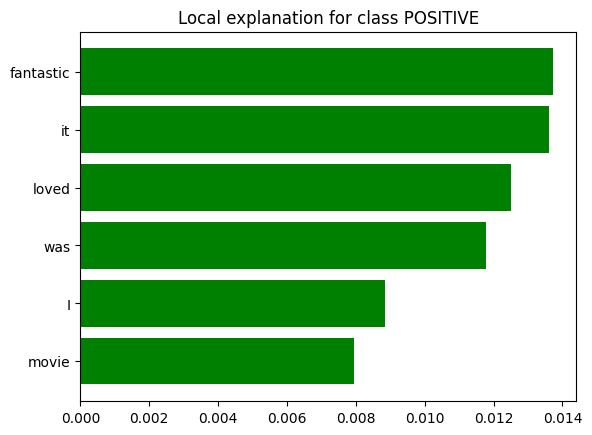

In [4]:
# Plot word importance
_ = exp.as_pyplot_figure(label=1)

# Show exact words in the text
html = exp.as_html(text=sample_text, labels=(1,))
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(html)

print("Open lime_explanation.html in browser or VS Code preview")

In [14]:
import numpy as np
import spacy
import torch
from anchor import anchor_text
from transformers import pipeline

# Setup
device = 0 if torch.cuda.is_available() else -1
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device
)

def predict_class(texts):
    """Return predicted class indices as 1D numpy array."""
    # Handle both single string and list inputs
    if isinstance(texts, str):
        texts = [texts]
    texts = list(texts)  # Ensure it's a list (Anchor may pass numpy array)
    
    results = classifier(texts)
    predictions = np.array([1 if res['label'] == 'POSITIVE' else 0 for res in results])
    return predictions

# Explainer
explainer = anchor_text.AnchorText(nlp=nlp, class_names=['NEGATIVE', 'POSITIVE'])

# Test the classifier first
text = "The Little Mermaid is a wonderful movie with stunning visuals and a captivating story."
print(f"Test prediction: {predict_class([text])}")
print(f"Test batch: {predict_class(['good movie', 'bad movie', 'okay'])}")

# Explain
explanation = explainer.explain_instance(
    text, 
    predict_class, 
    threshold=0.95,
    use_proba=False  # Explicitly use class predictions
)

# Results
pred = predict_class([text])[0]
print(f"\nText: {text}")
print(f"Prediction: {explainer.class_names[pred]}")
print(f"Anchor: {' AND '.join(explanation.names())}")
print(f"Precision: {explanation.precision():.2%} | Coverage: {explanation.coverage():.2%}")

Device set to use cpu


Test prediction: [1]
Test batch: [1 0 1]

Text: The Little Mermaid is a wonderful movie with stunning visuals and a captivating story.
Prediction: POSITIVE
Anchor: captivating
Precision: 100.00% | Coverage: 100.00%
